In [1]:
import pyvisa
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

#### System parameters

In [2]:
N = 15       # number of loops
lc = 0.1     # magnetic core length / m
l = 8.5e-2
w = 0.5e-2
ur = 70000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2

In [76]:
def get_data(fname):
    z = []
    B = []
    for i in range(1, 6):
        with h5py.File(fname, "a") as f:
            dset = f[f"R-{i}"]
            B0, B90, B180, B270, B360 = [dset[:, i] * 100 for i in range(5)]
            Bread = [B0, B90, B180, B270, B360]
            posi = int(dset.attrs["position"])
            B.append(Bread)
            z.append(posi)
    return B, z

In [77]:
fname = "hystersis_2_23_2024.hdf"
Vin = []
Vpick = []
Vamp = [0.5,1,2,5,10]
with h5py.File(fname, "a") as f:
    for i in range(1, 6):
        dset = f[f"R-{i}"]
        Vin.append(dset[0])
        Vpick.append(dset[1])

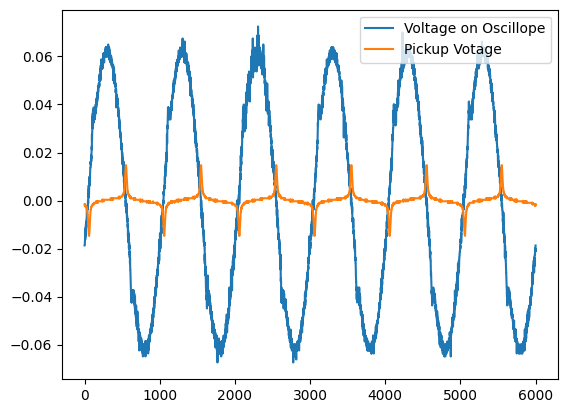

In [5]:
plt.plot(Vin[2], label =  "Voltage on Oscillope")
plt.plot(Vpick[2], label =  "Pickup Votage")
plt.legend()

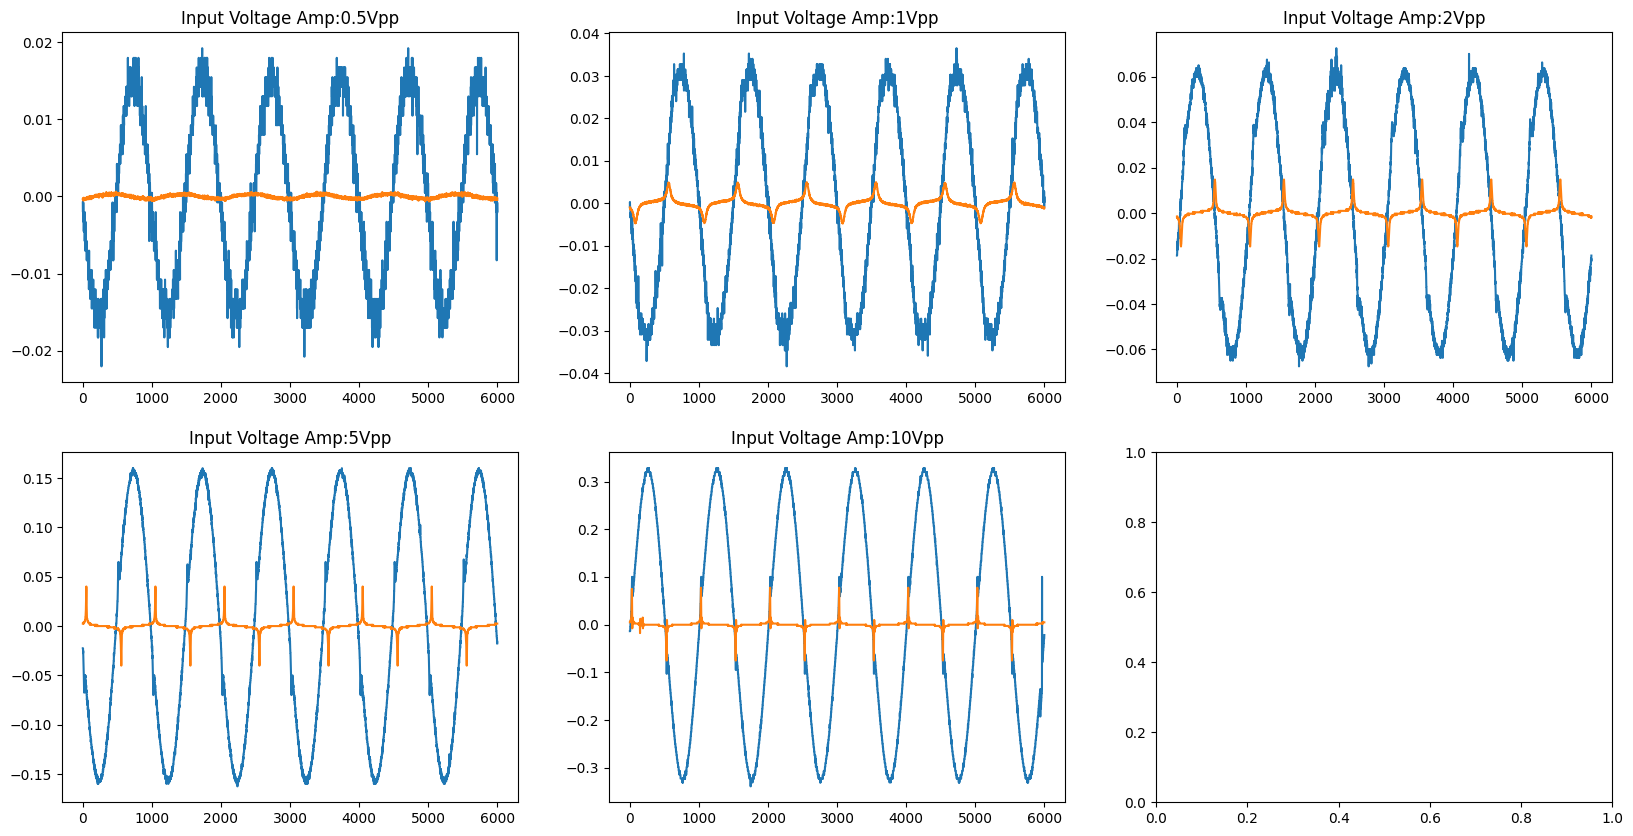

In [6]:
fig, ax = plt.subplots(2,3,figsize=(20, 10))
for i in range(5):
    if i < 3 :
        ax[0,i].plot(Vin[i])
        ax[0,i].plot(Vpick[i])
        ax[0,i].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
    else:
        ax[1,i-3].plot(Vin[i])
        ax[1,i-3].plot(Vpick[i])
        ax[1,i-3].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")

In [7]:
Vin = []
Vpick = []
fre =  ["50","100","500","1000","5000","20000"]
with h5py.File(fname, "a") as f:
    for i in fre:
        dset = f[f"{i}-1"]
        Vin.append(dset[0])
        Vpick.append(dset[1])

Text(0.5, 0.98, 'Input: 0.5Vpp')

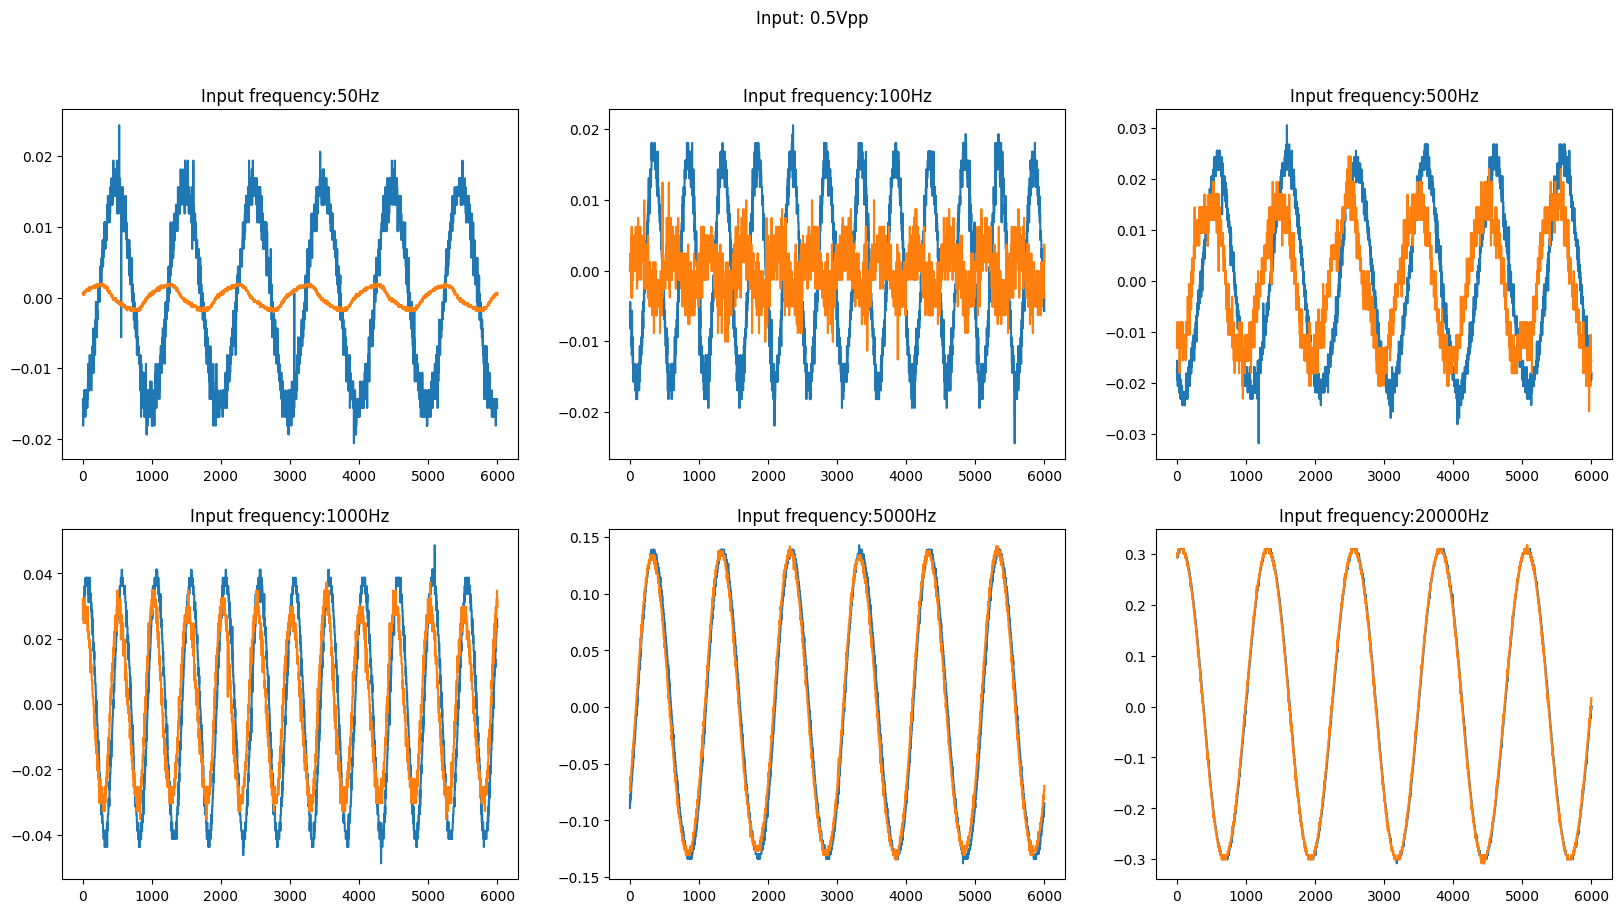

In [8]:
fig, ax = plt.subplots(2,3,figsize=(20, 10))
for i in range(6):
    if i < 3 :
        ax[0,i].plot(Vin[i])
        ax[0,i].plot(Vpick[i])
        ax[0,i].set_title("Input frequency:" + str(fre[i])+"Hz")
    else:
        ax[1,i-3].plot(Vin[i])
        ax[1,i-3].plot(Vpick[i])
        ax[1,i-3].set_title("Input frequency:" + str(fre[i])+"Hz")

fig.suptitle("Input: 0.5Vpp")

In [78]:
def test_func(x, a ,b, c):
    return a * np.sin(b * x + c)

def sin_fit(raw_data, Vset, fre, time_factor):
    x_data = np.linspace(0 , 6/fre, len(raw_data))
    y_data = raw_data
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=[0.5,time_factor*fre,0])
    plt.plot(x_data, y_data, '.', label='Data')
    plt.plot(x_data, test_func(x_data, params[0], params[1],params[2]),label='Fitted function',color = "r")
    plt.legend(loc='best')
    plt.show()
    return params, x_data

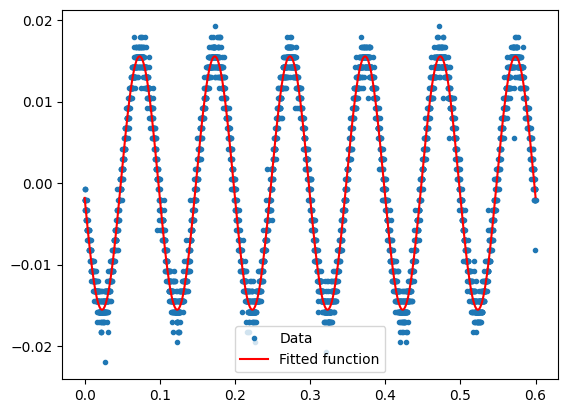

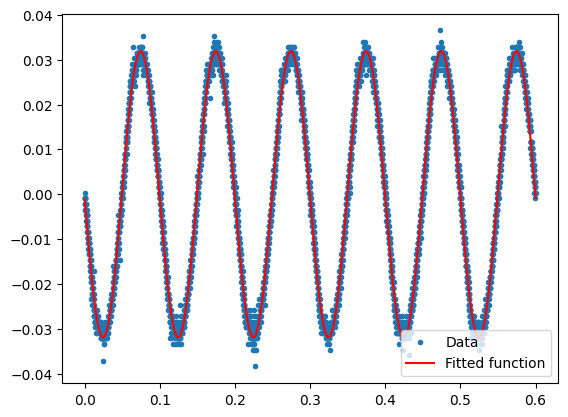

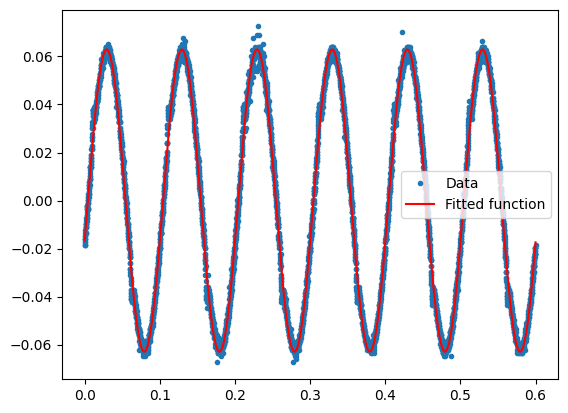

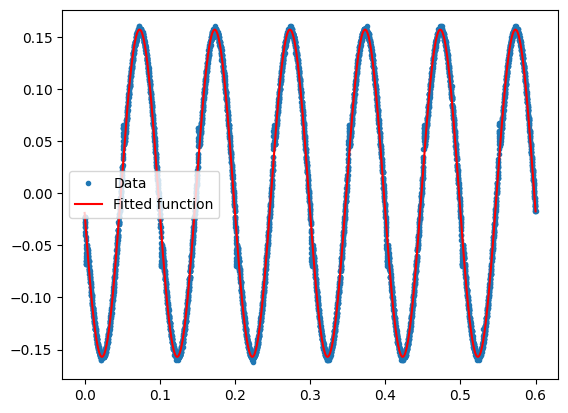

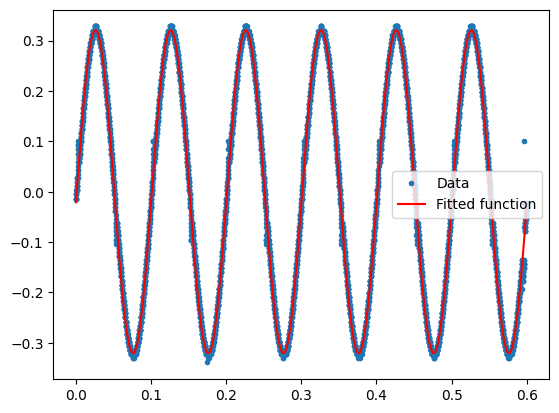

In [79]:
amp_fit = []
fre_fit = []
phase_fit = []
V_SGamp = []
for i in range(5):
    param,x = sin_fit(Vin[i],Vamp[i],10,6)
    amp_fit.append(param[0])
    fre_fit.append(param[1])
    phase_fit.append(param[2])
    if param[0] > 0:
        V_SGamp.append((2 * Vamp[i] - 2*abs(param[0]))/2)
    else:
        V_SGamp.append((-1* (2 * Vamp[i] - 2*abs(param[0])))/2)

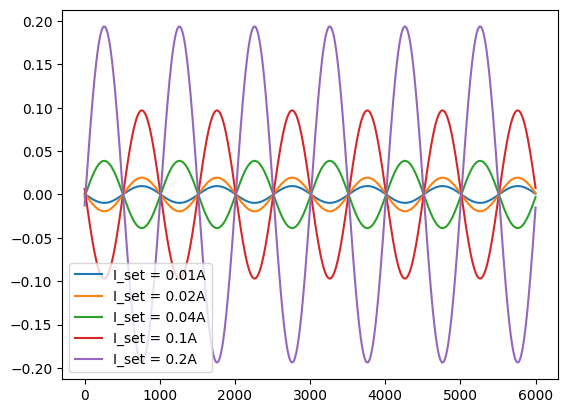

In [80]:
I = []
I_set = np.array(Vamp)/50
for i in range(5):
    V_SG = test_func(x, V_SGamp[i], param[1],param[2])
    I.append(V_SG /50)
    plt.plot(I[i], label  = "I_set = "+ str(I_set[i]) + "A")
    plt.legend()


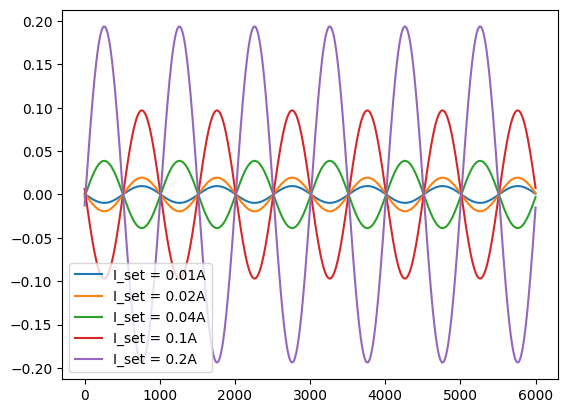

In [81]:
I = []
I_set = np.array(Vamp)/50
I_SGamp = np.array(V_SGamp)/50
for i in range(5):
    V_SG = test_func(x, V_SGamp[i], param[1],param[2])
    I.append(V_SG /50)
    plt.plot(I[i], label  = "I_set = "+ str(I_set[i]) + "A")
    plt.legend()

    

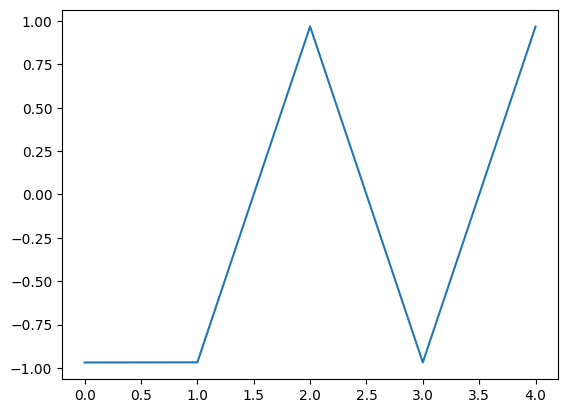

In [82]:
Vratio = [b / m for b,m in zip(I_SGamp, I_set)]
plt.plot(Vratio)

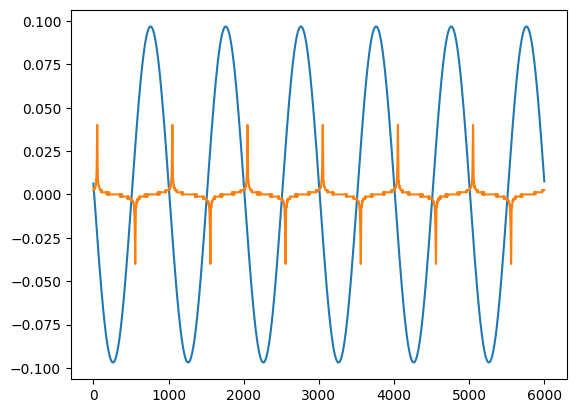

In [83]:
plt.plot(I[3])
plt.plot(Vpick[3])
Vpick[2] = -1* Vpick[2]
Vpick[3] = -1* Vpick[3]

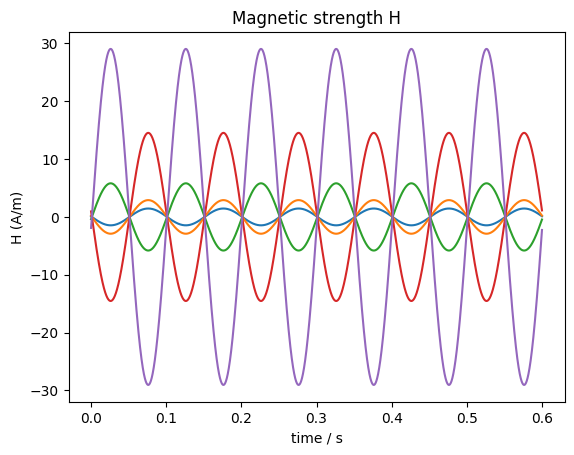

In [84]:
T = x
T_be = 1000e-4     # Begin time period
T_end = 2000e-4
T_per = 0.1            # Period length
dt = 1e-4/500              # time interval
Nt = 1000              # #of data points for integral
H = []
B = []
B_int = []
for i in range(5):
    H.append(np.array(I[i]) * N / lc)         # Magnetic field strength
    plt.plot(T,H[i])
    plt.xlabel("time / s")
    plt.ylabel("H (A/m)")
    plt.title("Magnetic strength H")
dB = np.array(Vpick)/Ac/N
for i in range(5):
    Bini = [0]
    for a in dB[i]:
        Bini.append(Bini[-1] + a * dt)
    B.append(Bini[1:])

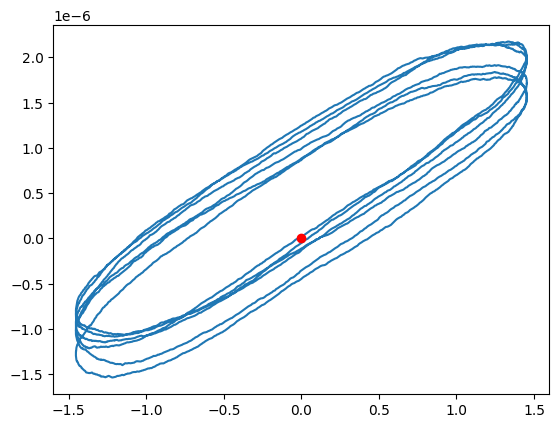

In [88]:
plt.plot(H[0],B[0])
plt.plot(0,0,"o",color = "r")

Text(0, 0.5, 'B (T)')

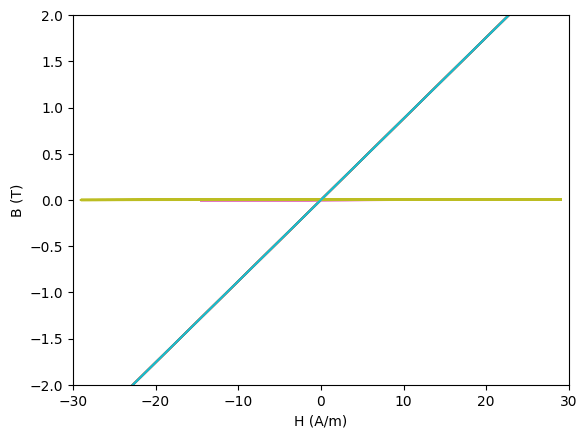

In [87]:
H_line = np.linspace(-60,60,12)
B_the = H_line * u
B_amped = []
for i in range(5):
    B_amped.append( np.array(B[i])*100)
    #plt.plot(H[i],B[i], label = "I amp = " + str(Vamp[i]/50))
    plt.plot(H[i],B_amped[i])
    plt.plot(H_line,B_the)
#plt.plot(0,0,"o",color = "r")
plt.xlim([-30,30])
plt.ylim([-2,2])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
#plt.legend()